<a href="https://colab.research.google.com/github/Pmskabir1234/Machine_Learning/blob/main/Health_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original shape: (4920, 133)
After drop_duplicates shape: (304, 133) (4616 rows removed)
Feature matrix shape: (304, 132)
Number of unique classes: 41
Train shape: (243, 132) Test shape: (61, 132)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 41)             │           697 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,817 (46.16 KB)

 Trainable params: 11,817 (46.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.0554 - loss: 3.7071 - val_accuracy: 0.0408 - val_loss: 3.7053
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0406 - loss: 3.6881 - val_accuracy: 0.0612 - val_loss: 3.6762
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0804 - loss: 3.6617 - val_accuracy: 0.1020 - val_loss: 3.6456
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0752 - loss: 3.6067 - val_accuracy: 0.1020 - val_loss: 3.6068
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1614 - loss: 3.5446 - val_accuracy: 0.1429 - val_loss: 3.5480
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0873 - loss: 3.4879 - val_accuracy: 0.1429 - val_loss: 3.4733
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1267 - loss: 3.3959 - val_accuracy: 0.1429 - val_loss: 3.3811
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1709 - loss: 3.2730 - val_accuracy: 0.1429 - val_los

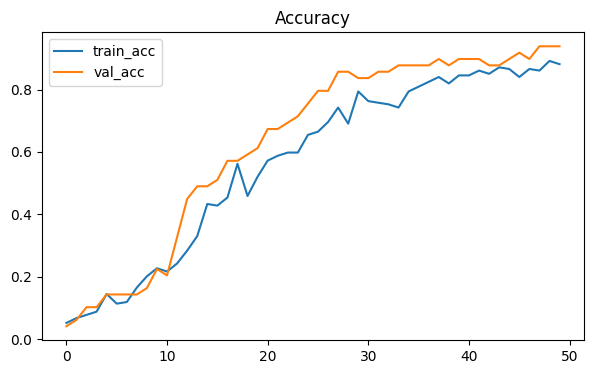

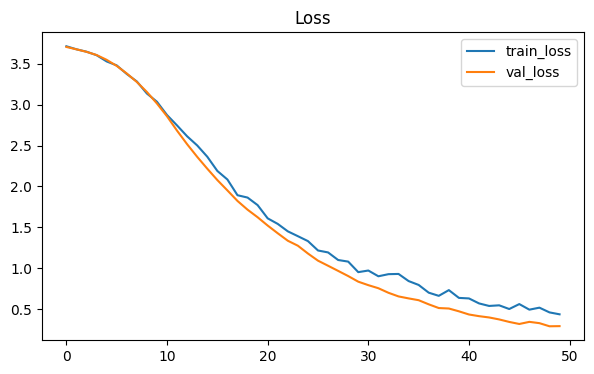

In [7]:
# train_and_infer.py
import re
import pickle
import string
import numpy as np
import pandas as pd
from difflib import get_close_matches
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

# --------------------------
# CONFIG
# --------------------------
CSV_PATH = "training_data.csv"      # your uploaded CSV
LABEL_COL = "prognosis"            # label column name in CSV
TEST_SIZE = 0.2
RANDOM_STATE = 42
VALIDATION_SPLIT = 0.2
MODEL_SAVE_PATH = "symptom_model.keras"
ENCODER_SAVE_PATH = "label_encoder.pkl"
SYMPTOM_KEYWORDS_MAP_PATH = "symptom_keywords.pkl"  # optional save of mapping
TOP_K = 3   # return top K predictions

# --------------------------
# UTILS: text cleaning + mapping
# --------------------------
def clean_text(s: str):
    s = s.lower()
    s = s.replace("-", " ")
    # remove punctuation
    s = s.translate(str.maketrans("", "", string.punctuation))
    # collapse whitespace
    s = re.sub(r"\s+", " ", s).strip()
    return s

def build_symptom_list(columns):
    """
    Given feature column names, create normalized symptom tokens
    and some lightweight variants. We'll use these for quick keyword matching.
    """
    symptom_names = []
    for c in columns:
        tok = c.lower().strip()
        tok = tok.replace("_", " ")
        tok = re.sub(r"\s+", " ", tok)
        symptom_names.append(tok)
    return symptom_names

def text_to_feature_vector(text: str, symptom_names):
    """
    Convert an English symptom text into the binary (0/1) feature vector
    matching the order of symptom_names.
    Strategy:
      - Lowercase & clean the input
      - If a symptom name (or a close token) appears in the text -> mark 1
      - Also check tokens (split words) and use difflib.get_close_matches for fuzzy matches
    """
    text_clean = clean_text(text)
    tokens = text_clean.split()
    vector = np.zeros(len(symptom_names), dtype=np.float32)

    # create quick lookup: symptom -> index
    symptom_to_index = {s: i for i, s in enumerate(symptom_names)}

    # direct substring match (best)
    for i, s in enumerate(symptom_names):
        if s in text_clean:
            vector[i] = 1.0

    # token-level fuzzy match as a fallback
    # build a set of text tokens for matching
    token_set = set(tokens)
    for token in token_set:
        # try to match token to symptom names
        matches = get_close_matches(token, symptom_names, n=5, cutoff=0.85)
        for m in matches:
            idx = symptom_to_index[m]
            vector[idx] = 1.0

    # also try multi-word tokens split by spaces. If user wrote "sore throat",
    # but symptom is "throat pain" we may still hit direct substring; above handles it.
    return vector

# --------------------------
# LOAD, CLEAN, DEDUPE
# --------------------------
df = pd.read_csv(CSV_PATH)

# Basic cleaning: replace common missing tokens with 0
df.replace(["NaN", "NULL", "NA", "?", "", " " , np.nan], 0, inplace=True)

# Remove the accidental Unnamed column if it exists
unnamed_cols = [c for c in df.columns if c.startswith("Unnamed")]
if unnamed_cols:
    df.drop(columns=unnamed_cols, inplace=True)

print("Original shape:", df.shape)

# drop exact duplicate rows (both features+label)
df_before = df.shape[0]
df = df.drop_duplicates()
print("After drop_duplicates shape:", df.shape, f"({df_before - df.shape[0]} rows removed)")

# If dataset is extremely small after dedupe, warn the user
if df.shape[0] < 50:
    print("⚠️ Warning: very few unique samples after dedupe:", df.shape[0])

# --------------------------
# Prepare X, y
# --------------------------
# ensure label column exists
if LABEL_COL not in df.columns:
    raise ValueError(f"Label column '{LABEL_COL}' not found in CSV columns: {df.columns.tolist()}")

X_df = df.drop(columns=[LABEL_COL])
y_series = df[LABEL_COL]

# list of symptom names from columns
symptom_names = build_symptom_list(X_df.columns.tolist())

# Convert X_df to numeric matrix (float)
# If X_df is already 0/1 columns (which I expect), we can use .values directly
X = X_df.values.astype(np.float32)
y_raw = y_series.values

print("Feature matrix shape:", X.shape)
print("Number of unique classes:", len(np.unique(y_raw)))

# --------------------------
# Label encoding
# --------------------------
le = LabelEncoder()
y_enc = le.fit_transform(y_raw)

# Save encoder for inference
with open(ENCODER_SAVE_PATH, "wb") as f:
    pickle.dump(le, f)

# --------------------------
# Train/test split
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=TEST_SIZE, stratify=y_enc, random_state=RANDOM_STATE
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# --------------------------
# Build the model (small dataset friendly)
# --------------------------
num_features = X_train.shape[1]
num_classes = len(np.unique(y_enc))

model = Sequential([
    Dense(64, input_shape=(num_features,), activation="relu"),
    Dropout(0.25),
    Dense(32, activation="relu"),
    Dropout(0.25),
    Dense(16, activation="relu"),
    Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

# --------------------------
# Train
# --------------------------
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=VALIDATION_SPLIT,
    verbose=1
)

# Save model
model.save(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

# --------------------------
# Evaluate
# --------------------------
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", loss, "Test Acc:", acc)

# Plot curves
plt.figure(figsize=(7,4))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend(); plt.title("Accuracy"); plt.show()

plt.figure(figsize=(7,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss"); plt.show()

# --------------------------
# Inference function: text -> prediction
# --------------------------
# We'll keep the trained model and encoder in memory.
# But also create helper functions that can load saved models/encoder if needed.

In [8]:

def load_model_and_encoder(model_path=MODEL_SAVE_PATH, encoder_path=ENCODER_SAVE_PATH):
    loaded_model = tf.keras.models.load_model(model_path)
    with open(encoder_path, "rb") as f:
        loaded_le = pickle.load(f)
    return loaded_model, loaded_le

def predict_from_text(text: str, top_k=TOP_K, model_obj=None, le_obj=None):
    """
    Convert english text -> feature vector -> model.predict -> top_k label(s) with confidence.
    Returns list of (disease_name, confidence) pairs sorted by confidence desc.
    """
    if model_obj is None or le_obj is None:
        m, le_local = load_model_and_encoder()
    else:
        m, le_local = model_obj, le_obj

    vec = text_to_feature_vector(text, symptom_names)
    vec = vec.reshape(1, -1).astype(np.float32)
    probs = m.predict(vec)[0]
    top_idx = np.argsort(probs)[-top_k:][::-1]
    results = [(le_local.inverse_transform([i])[0], float(probs[i])) for i in top_idx]
    return results

# quick test example (change text to match your symptoms)
sample_text = "I have fever and headache with nausea"
print("\nSample inference for text:", sample_text)
print(predict_from_text(sample_text))

# Save symptom_names mapping for later use (optional)
with open(SYMPTOM_KEYWORDS_MAP_PATH, "wb") as f:
    pickle.dump(symptom_names, f)

print("\nAll done — you can now call predict_from_text(text) to get predictions.")
import gradio as gr
import re

# Load model & encoder
model_loaded, le_loaded = load_model_and_encoder()

# Get list of known symptoms from your training data
known_symptoms = symptom_names

def extract_symptoms(user_text):
    """Match user text against known symptoms (case-insensitive)."""
    user_text = user_text.lower()
    matched = [sym for sym in known_symptoms if re.search(rf"\b{sym}\b", user_text)]
    return matched

def gradio_predict(text):
    matched_symptoms = extract_symptoms(text)
    if not matched_symptoms:
        return "❌ No known symptoms detected. Try rephrasing.", ""

    results = predict_from_text(
        ", ".join(matched_symptoms),
        top_k=3,
        model_obj=model_loaded,
        le_obj=le_loaded
    )

    predictions = "\n".join([f"{disease} ({conf:.2f})" for disease, conf in results])
    matched = ", ".join(matched_symptoms)

    return predictions, f"✅ Symptoms understood: {matched}"

demo = gr.Interface(
    fn=gradio_predict,
    inputs=gr.Textbox(lines=2, placeholder="Type symptoms here (e.g., 'fever, cough, sore throat')"),
    outputs=["text", "text"],
    title="Symptom → Disease Predictor",
    description="Type your symptoms in plain English. The app will show which symptoms it understood and the top-3 predicted diseases."
)

demo.launch()



Sample inference for text: I have fever and headache with nausea
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
[('Malaria', 0.2538530230522156), ('(vertigo) Paroymsal  Positional Vertigo', 0.18109197914600372), ('Dengue', 0.11345422267913818)]

All done — you can now call predict_from_text(text) to get predictions.
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://93c57af4cd70e63ccb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
